https://www.youtube.com/watch?v=jF43_wj_DCQ&list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN&index=6&pp=iAQB

### Dataset and DataLoader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

torch.multiprocessing.set_sharing_strategy('file_system')
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=4)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


T-shirt/top   Coat   Bag   Ankle Boot


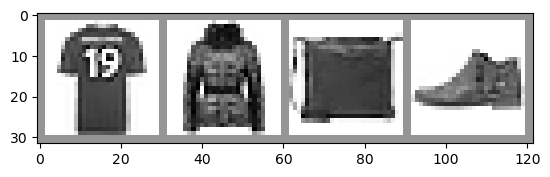

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
print('   '.join(classes[labels[j]] for j in range(4)))
matplotlib_imshow(img_grid, one_channel=True)

### The Model

In [3]:
import torch.nn  as nn
import torch.nn.functional as F

# Variant of LeNet-5
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = GarmentClassifier()
print(model)

GarmentClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Loss Functions

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(4,10)
dummy_labels = torch.tensor([1,5,3,7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.4169, 0.4712, 0.4313, 0.0392, 0.0275, 0.5476, 0.7795, 0.5462, 0.9280,
         0.6288],
        [0.3429, 0.3384, 0.2735, 0.3505, 0.1494, 0.5516, 0.5225, 0.7876, 0.4212,
         0.6593],
        [0.3573, 0.9626, 0.8952, 0.0823, 0.6199, 0.7635, 0.9119, 0.3163, 0.3870,
         0.7980],
        [0.4067, 0.0325, 0.4926, 0.6410, 0.6338, 0.0185, 0.8619, 0.8820, 0.7888,
         0.9055]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.364306926727295


### Optimizer

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### The Training Loop

In [6]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data
        
        # Zero the gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Per-Epoch Activity

In [7]:
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [10]:
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number+1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i+1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss', { 'Training' : avg_loss, 'Validataion' : avg_vloss }, epoch_number+1)
    writer.flush()
  
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 6:
  batch 1000 loss 0.2658486292197922
  batch 2000 loss 0.2630033697149629
  batch 3000 loss 0.26631713598758144
  batch 4000 loss 0.25171265662793485
  batch 5000 loss 0.27604081549991405
  batch 6000 loss 0.2601625058490572
  batch 7000 loss 0.25388678106239515
  batch 8000 loss 0.25808189037314694
  batch 9000 loss 0.2776588405236689
  batch 10000 loss 0.2742039644359238
  batch 11000 loss 0.2866728334586005
  batch 12000 loss 0.2817606930511192
  batch 13000 loss 0.2702535711697419
  batch 14000 loss 0.27150332208158945
  batch 15000 loss 0.2511101939220266
LOSS train 0.2511101939220266 valid 0.30434146523475647
EPOCH 7:
  batch 1000 loss 0.26271829537918256
  batch 2000 loss 0.24837987989073917
  batch 3000 loss 0.2496601567660018
  batch 4000 loss 0.2536980415442449
  batch 5000 loss 0.24366643459701665
  batch 6000 loss 0.26466611780742644
  batch 7000 loss 0.25489397011479
  batch 8000 loss 0.24629483556169543
  batch 9000 loss 0.24811975223214994
  batch 10000 loss 0.2